# DBSCAN

## Overview

The DBSCAN clustering approach is quite novel.  It allows us to find things based on similarity that other clustering methods are not very good at finding.  It also allows clusters to take on any shape, meaning that a cluster could be found within the boundary of another cluster.  This method can be very useful in finding anomalous behaviors in our networks, but it does require us to spend some time thinking about how to represent our data in a meaningful way.

## Goals

In this lab, we will accomplish the following:

* Create transformation functions to produce numeric output from textual input
* Apply the DBSCAN clustering algorithm to our data
* Visualize the resulting clusters
* Attempt to identify anomalies in the clusters

 
## Estimated Time: 30 - 45 minutes

No doubt you have come to appreciate that applying these various techniques to our data requires that our data be transformed to some numeric representation if it is not already numeric in nature.  This lab brings this issue to the fore.

In this lab, we will examine the DNS log data produced by Zeek or Corelight.  The premise of our analysis is that there might be interesting clusters in our DNS data, specifically with regard to the names of hosts that are resolved.  To this end, we are going to attempt to use a clustering technique to identify similarities in queries.  Along the way we hope to identify potential anomalous queries, which can drive further investigation by a SOC.

# <img src="../images/task.png" width=20 height=20> Task 3.1

The data we are working with in this lab is located in `../data/Day 3/dns.log`.  If you look at this data, you will find that its structure is similar to, but not the same as, the `conn.log` file that we examined in the last two labs.

Using the following cell, import all required libraries and read this DNS data into a Pandas dataframe.

In [3]:
import pandas as pd
import numpy as np

In [4]:
with open("../data/Day 3/dns.log", 'r') as f:
    lines = f.readlines()
    line = lines[6]
    columns = line.rstrip().split("\t")[1:]

df = pd.read_csv("../data/Day 3/dns.log", sep="\t", skiprows=8, names=columns)
df

/tmp/ipykernel_518/1363220855.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Day 3/dns.log", sep="\t", skiprows=8, names=columns)


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
0,1556714128.452636,CIi13n4wz8DvZJlQ89,192.168.50.25,50074.0,8.8.8.8,53.0,udp,6202.0,0.036838,tile-service.weather.microsoft.com,...,0,NOERROR,F,F,T,T,0.0,"wildcard.weather.microsoft.com.edgekey.net,e70...","404.000000,417.000000,19.000000",F
1,1556714174.956009,CZbxTe1Scwvgvanop9,192.168.50.25,49869.0,8.8.8.8,53.0,udp,20785.0,0.014214,www.msn.com,...,0,NOERROR,F,F,T,T,0.0,"www-msn-com.a-0003.a-msedge.net,a-0003.a-msedg...","78.000000,27.000000,27.000000",F
2,1556714176.179854,C9To8V1Pat2ibPjZae,192.168.50.25,51367.0,8.8.8.8,53.0,udp,6174.0,0.113166,static-spartan-eus-s-msn-com.akamaized.net,...,0,NOERROR,F,F,T,T,0.0,"a1903.g2.akamai.net,167.206.87.27,167.206.87.32","886.000000,19.000000,19.000000",F
3,1556714176.669248,CQV1hk49nFqYmspQA3,192.168.50.25,51591.0,8.8.8.8,53.0,udp,36753.0,0.042259,img-s-msn-com.akamaized.net,...,0,NOERROR,F,F,T,T,0.0,"a1834.dspg2.akamai.net,167.206.87.48,167.206.8...","894.000000,19.000000,19.000000",F
4,1556714177.024688,C2MbVf3MY3yz5C6dW2,192.168.50.25,51683.0,8.8.8.8,53.0,udp,41758.0,0.095731,img.s-msn.com,...,0,NOERROR,F,F,T,T,0.0,"wildcard.s-msn.com.edgekey.net,e7341.g.akamaie...","2923.000000,20946.000000,19.000000",F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57141,1556896704.968338,CiFoPh4DSWw4XDCtDh,192.168.50.25,50531.0,8.8.8.8,53.0,udp,28225.0,-,chat.freenode.net,...,-,-,F,F,T,F,0.0,-,-,F
57142,1556896698.180543,CbMPrUFOYWRMHDL23,192.168.10.25,59170.0,8.8.8.8,53.0,udp,54230.0,-,detectify.com,...,-,-,F,F,T,F,0.0,-,-,F
57143,1556896703.185281,CbMPrUFOYWRMHDL23,192.168.10.25,59170.0,8.8.8.8,53.0,udp,54230.0,-,detectify.com,...,-,-,F,F,T,F,0.0,-,-,F
57144,1556896708.190451,CbMPrUFOYWRMHDL23,192.168.10.25,59170.0,8.8.8.8,53.0,udp,54230.0,-,detectify.com,...,-,-,F,F,T,F,0.0,-,-,F


Let's perform some initial cleaning of the data.  Once again, the final row of the data just marks the log as closed.  Additionally, we can safely drop the timestamp, uid, originating host, port, responding host, and protocol.

# <img src="../images/task.png" width=20 height=20> Task 3.2

Please delete the data from the dataframe indicated above.

In [5]:
df.drop([57145], inplace=True)
df.drop(columns=['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto'], inplace=True)
df

,trans_id,rtt,query,qclass,qclass_name,qtype,qtype_name,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
0,6202.0,0.036838,tile-service.weather.microsoft.com,1.0,C_INTERNET,1.0,A,0,NOERROR,F,F,T,T,0.0,"wildcard.weather.microsoft.com.edgekey.net,e70...","404.000000,417.000000,19.000000",F
1,20785.0,0.014214,www.msn.com,1.0,C_INTERNET,1.0,A,0,NOERROR,F,F,T,T,0.0,"www-msn-com.a-0003.a-msedge.net,a-0003.a-msedg...","78.000000,27.000000,27.000000",F
2,6174.0,0.113166,static-spartan-eus-s-msn-com.akamaized.net,1.0,C_INTERNET,1.0,A,0,NOERROR,F,F,T,T,0.0,"a1903.g2.akamai.net,167.206.87.27,167.206.87.32","886.000000,19.000000,19.000000",F
3,36753.0,0.042259,img-s-msn-com.akamaized.net,1.0,C_INTERNET,1.0,A,0,NOERROR,F,F,T,T,0.0,"a1834.dspg2.akamai.net,167.206.87.48,167.206.8...","894.000000,19.000000,19.000000",F
4,41758.0,0.095731,img.s-msn.com,1.0,C_INTERNET,1.0,A,0,NOERROR,F,F,T,T,0.0,"wildcard.s-msn.com.edgekey.net,e7341.g.akamaie...","2923.000000,20946.000000,19.000000",F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57140,37157.0,-,s.amigo.mail.ru,1.0,C_INTERNET,1.0,A,-,-,F,F,T,F,0.0,-,-,F
57141,28225.0,-,chat.freenode.net,1.0,C_INTERNET,1.0,A,-,-,F,F,T,F,0.0,-,-,F
57142,54230.0,-,detectify.com,1.0,C_INTERNET,15.0,MX,-,-,F,F,T,F,0.0,-,-,F
57143,54230.0,-,detectify.com,1.0,C_INTERNET,15.0,MX,-,-,F,F,T,F,0.0,-,-,F


Looking at the columns that remain, it seems we can likely do some additional cleaning and also process some categorical data.

# <img src="../images/task.png" width=20 height=20> Task 3.3

The `qclass` and `qtype` might be good values to keep.  These are numeric categories used in the DNS protocol to indicate the type and class of the query.  The related `name` fields, however, are redundant and are not numbers.  Similarly, the `rcode_name` isn't useful for us since there is already an `rcode` value.

A few other fields that are likely not useful are the `AA`, `TC`, `RD`, `RA`, and `Z` columns.  These indicate the status of various bits in the DNS header.  We can drop these as well for our experiment, though we may wish to include them in other clustering experiments.  The `rejected` value seems interesting, but we will ignore it for the time being.

The `trans_id` or *transaction ID* is an arbitrary number sent in the query.  It might be interesting to find lots of duplicates, which would be anomalous, but this column might prove distracting for the moment.  The same might be true of the `rtt`, or *round trip time* field.  There might be some interesting future analysis to perform with this field, but we will ignore it for now.

We *definitely* want to preserve the query field in some way, but how?  We'll think about that soon. The same is true of the `TTL` field. The `answers` column is also interesting, but will also require processing.

Drop all of the columns described above that seem less useful for now.  ***Do not delete the answers, query, or ttl fields!***

In [6]:
df.drop(columns=['qclass_name', 'qtype_name', 'rcode_name', 'AA', 'TC', 'RD', 'RA', 'Z', 'rejected', 'trans_id', 'rtt'], inplace=True)
df

,query,qclass,qtype,rcode,answers,TTLs
0,tile-service.weather.microsoft.com,1.0,1.0,0,"wildcard.weather.microsoft.com.edgekey.net,e70...","404.000000,417.000000,19.000000"
1,www.msn.com,1.0,1.0,0,"www-msn-com.a-0003.a-msedge.net,a-0003.a-msedg...","78.000000,27.000000,27.000000"
2,static-spartan-eus-s-msn-com.akamaized.net,1.0,1.0,0,"a1903.g2.akamai.net,167.206.87.27,167.206.87.32","886.000000,19.000000,19.000000"
3,img-s-msn-com.akamaized.net,1.0,1.0,0,"a1834.dspg2.akamai.net,167.206.87.48,167.206.8...","894.000000,19.000000,19.000000"
4,img.s-msn.com,1.0,1.0,0,"wildcard.s-msn.com.edgekey.net,e7341.g.akamaie...","2923.000000,20946.000000,19.000000"
...,...,...,...,...,...,...
57140,s.amigo.mail.ru,1.0,1.0,-,-,-
57141,chat.freenode.net,1.0,1.0,-,-,-
57142,detectify.com,1.0,15.0,-,-,-
57143,detectify.com,1.0,15.0,-,-,-


Let's think about the answers column.  If you look at the first entry in that column, you will see that the value is a comma separated string value.  We'd like to turn that into some kind of number.  What if we were to simply count how many characters are in the aggregate answers?

We can replace all of the values in a column (or *Series*) in a Pandas dataframe by simply assigning to it.  What we need is an easy way to obtain the length of each of the rows in that column.

If your initial thought is to use a list comprehension, that is a wonderful idea.  However, it turns out that Pandas has a variety of convenience methods attached to the `Series` class (of which each column is an instance).  One of these, `str`, allows us to treat it as a series of strings.  This has yet another method, `len()`, which will return the length of each value.

So, we could do something like:

```
df['answers'] = df['answers'].str.len()
```

# <img src="../images/task.png" width=20 height=20> Task 3.4

Replace the `answers` column with the length of each of the answers found in that column.

In [7]:
df['answers'] = df['answers'].str.len()
df

,query,qclass,qtype,rcode,answers,TTLs
0,tile-service.weather.microsoft.com,1.0,1.0,0,80,"404.000000,417.000000,19.000000"
1,www.msn.com,1.0,1.0,0,66,"78.000000,27.000000,27.000000"
2,static-spartan-eus-s-msn-com.akamaized.net,1.0,1.0,0,47,"886.000000,19.000000,19.000000"
3,img-s-msn-com.akamaized.net,1.0,1.0,0,50,"894.000000,19.000000,19.000000"
4,img.s-msn.com,1.0,1.0,0,69,"2923.000000,20946.000000,19.000000"
...,...,...,...,...,...,...
57140,s.amigo.mail.ru,1.0,1.0,-,1,-
57141,chat.freenode.net,1.0,1.0,-,1,-
57142,detectify.com,1.0,15.0,-,1,-
57143,detectify.com,1.0,15.0,-,1,-


Let's turn our attention to the `TTLs` column.  First, you may notice that the last few rows contain `-` characters.  These will prove inconvenient shortly.  We want to treat this column as a list of floating point values and sum them.  The `-` characters will cause an error to be thrown.

Since this value is trying to indicate that there is no TTL present, perhaps we should replace each of these with a negative value, like $-1$, since this value can never occur in real data.

To do this, we could use something like:

```
df['TTLs'] = df['TTLs'].replace('-', '-1', inplace=True)
```

Next, we want to replace the `TTLs` column with the sum of the values in each row in the column.  In other words, if one of the rows contains `1, 2, 3` in the `TTLs` column, we want to replace those values with the single value `6`.

There are many approaches we might take to this.  Pandas has an `apply()` function that can be used to apply any function to each value in a series.  For example:

```
def square(x):
    return x**2
    
df['squared_answers'] = df['answers'].apply(square)
```

This will add a column named `squared_answers` to our dataframe.  Each row will contain the square of the corresponding `answers` field.

# <img src="../images/task.png" width=20 height=20> Task 3.5

Using `replace()` and `apply()`, convert the `TTLs` column.  Replace `-` values with `-1`.  Replace the `TTLs` column with the sum of the TTLs that are present in the list of values.  The `rcode` column also contains `-` values.  Replace these with `-1` as well.

In [8]:
def sum_TTLs(str_list):
    nums = str_list.split(',')  # Split multiple values first
    return np.array(nums, dtype=np.float32).sum()  # Then take their sum

df['TTLs'].replace('-', '-1', inplace=True)  # First replace '-' with '-1'
df['rcode'].replace('-', '-1', inplace=True) # Clean up the 'rcode' field too
df['TTLs'] = df['TTLs'].apply(sum_TTLs)      # Now apply the transformation to every row

/tmp/ipykernel_518/837388016.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TTLs'].replace('-', '-1', inplace=True)  # First replace '-' with '-1'
/tmp/ipykernel_518/837388016.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [9]:
df

,query,qclass,qtype,rcode,answers,TTLs
0,tile-service.weather.microsoft.com,1.0,1.0,0,80,840.0
1,www.msn.com,1.0,1.0,0,66,132.0
2,static-spartan-eus-s-msn-com.akamaized.net,1.0,1.0,0,47,924.0
3,img-s-msn-com.akamaized.net,1.0,1.0,0,50,932.0
4,img.s-msn.com,1.0,1.0,0,69,23888.0
...,...,...,...,...,...,...
57140,s.amigo.mail.ru,1.0,1.0,-1,1,-1.0
57141,chat.freenode.net,1.0,1.0,-1,1,-1.0
57142,detectify.com,1.0,15.0,-1,1,-1.0
57143,detectify.com,1.0,15.0,-1,1,-1.0


Let's think about how to process the DNS names that show up in the queries.  We definitely want to look at these, but cannot look at them as text.  Our next inclination might be to treat it as categorical data (which it probably is), but there are nearly 6,300 unique values that show up in queries.  We really don't want to add 6,300 columns to our data!

What if we were to transform them in some way?  Consider this idea:

Create new columns that store:
* The total length of the query
* The number of parts in the query name
* The length of the suffix (.com, .net, info, etc.)
* The length of the domain (google, akamai, amazon, etc.)

While it would be very difficult to reconstitute a query from this data, it does provide a way to transform any query name into a set of values.  Pandas makes it pretty convenient to add a column to our data, provided it has the same number of rows as our existing dataframe:

```
df['new_column'] = array_of_values
```

# <img src="../images/task.png" width=20 height=20> Task 3.6

Armed with the information and the approach above, create four functions:

* `query_length()`
* `query_parts()`
* `query_suffix_length()`
* `query_domain_length()`

These functions should return the appropriate values based on the approach suggested above.  Use these functions to build four new columns and add these columns to the existing dataframe using the column names, `qlength`, `qparts`, `suffixlength`, `domainlength`.

In [10]:
def query_length(query):
    return len(query)

def query_parts(query):
    return len(query.split('.'))

def query_suffix_length(query):
    return len(query.split('.')[-1])

def query_domain_length(query):
    try:
        length =  len(query.split('.')[-2])
    except:
        length = 0
    return length

qlengths = [query_length(query) for query in df['query']]
qparts = [query_parts(query) for query in df['query']]
qsufflengths = [query_suffix_length(query) for query in df['query']]
qdomlengths = [query_domain_length(query) for query in df['query']]

df['qlength'] = qlengths
df['qparts'] = qparts
df['suffixlength'] = qsufflengths
df['domainlength'] = qdomlengths
df

,query,qclass,qtype,rcode,answers,TTLs,qlength,qparts,suffixlength,domainlength
0,tile-service.weather.microsoft.com,1.0,1.0,0,80,840.0,34,4,3,9
1,www.msn.com,1.0,1.0,0,66,132.0,11,3,3,3
2,static-spartan-eus-s-msn-com.akamaized.net,1.0,1.0,0,47,924.0,42,3,3,9
3,img-s-msn-com.akamaized.net,1.0,1.0,0,50,932.0,27,3,3,9
4,img.s-msn.com,1.0,1.0,0,69,23888.0,13,3,3,5
...,...,...,...,...,...,...,...,...,...,...
57140,s.amigo.mail.ru,1.0,1.0,-1,1,-1.0,15,4,2,4
57141,chat.freenode.net,1.0,1.0,-1,1,-1.0,17,3,3,8
57142,detectify.com,1.0,15.0,-1,1,-1.0,13,2,3,9
57143,detectify.com,1.0,15.0,-1,1,-1.0,13,2,3,9


Let's pull some of these columns out into a numpy array.  We will then use this with DBSCAN to see if we can find and visualize some clusters.

# <img src="../images/task.png" width=20 height=20> Task 3.7

Build a Numpy array using the query length, query parts, suffix length, qclass, qtype, rcode, answers, TTLs, and domain length columns.

In [11]:
data = df[['qlength', 'qparts', 'suffixlength', 'qclass',
           'qtype', 'rcode', 'answers', 'TTLs', 'domainlength']].to_numpy()
data

array([[34, 4, 3, ..., 80, 840.0, 9],
       [11, 3, 3, ..., 66, 132.0, 3],
       [42, 3, 3, ..., 47, 924.0, 9],
       ...,
       [13, 2, 3, ..., 1, -1.0, 9],
       [13, 2, 3, ..., 1, -1.0, 9],
       [13, 2, 3, ..., 1, -1.0, 9]], dtype=object)

It's now time to process this using DBSCAN.  To do so, we need to import the DBSCAN class from the Scikit Learn Clustering package.  We also know that we would like to visualize this data, so let's also import the PCA package for dimensionality reduction.

One of the wonderful things about DBSCAN is that we do not need to define the number of clusters.  Recall that one of the things that the algorithm does is figure out the number of clusters based on the distance from discovered cluster "centers."

To use DBSCAN, we use an approach similar to the following:

```
dbscan = DBSCAN() # Accept defaults for epsilon and minimum points
dbscan.fit(data)
y_labels = dbscan.labels_
```

This will store the various cluster assignments into `y_labels`.

# <img src="../images/task.png" width=20 height=20> Task 3.8

Do the following:

 * Use `StandardScaler` to scale the data.  Store the scaled data into a variable named `scaled`.
 * Generate an $\mathbb{R}^3$ representation of the scaled data.  Store this in a variable named `reduced`.
 * Cluster the data using DBScan; set $\epsilon=0.8$ and minimum samples for cluster formation set to 5.
 * Extract the labels by accessing `dbscan.labels_` on your `DBScan` object.

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a scaled copy of the data
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)

# Apply a PCA 3 to the scaled data
pca = PCA(3)
pca.fit(scaled)
reduced = pca.transform(scaled)

# Cluster the scaled data using the values provided in the instructions
dbscan = DBSCAN(n_jobs=-1, min_samples=5, eps=0.8)
dbscan.fit(scaled)

# Copy the labels
y_labels = dbscan.labels_
np.unique(y_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20])

In [13]:
len(np.unique(y_labels))

22


# <img src="../images/task.png" width=20 height=20> Task 3.9

We'd now like to do some plotting.  Please go back to your last lab and copy your 3d scatterplot function.  Paste that in here and modify it as needed to render the DBSCAN clusters that we have generated.  When generating the plot, create a plot that excludes the outliers (values whose labels are -1) and another that is only outliers (values whose labels are -1).

Plotting Isometric...
Plotting Along X...
Plotting Along Y...
Plotting Along Z...


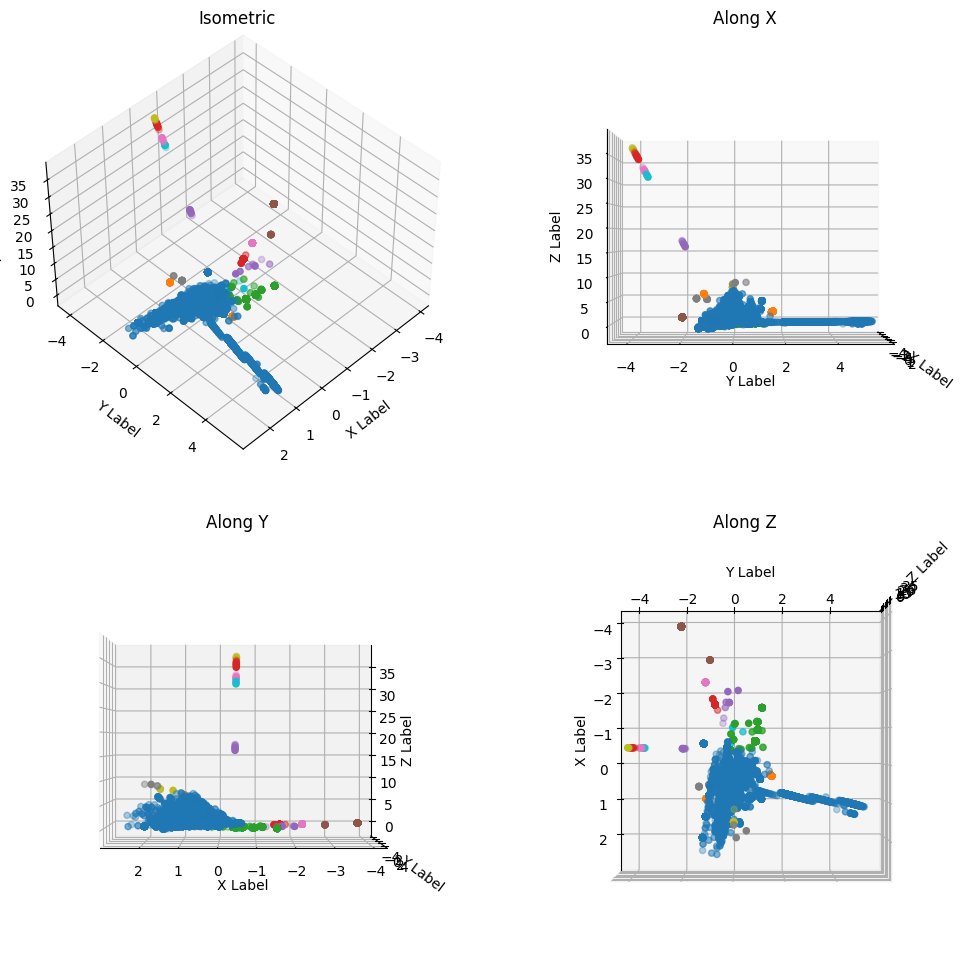

Plotting Isometric...
Plotting Along X...
Plotting Along Y...
Plotting Along Z...


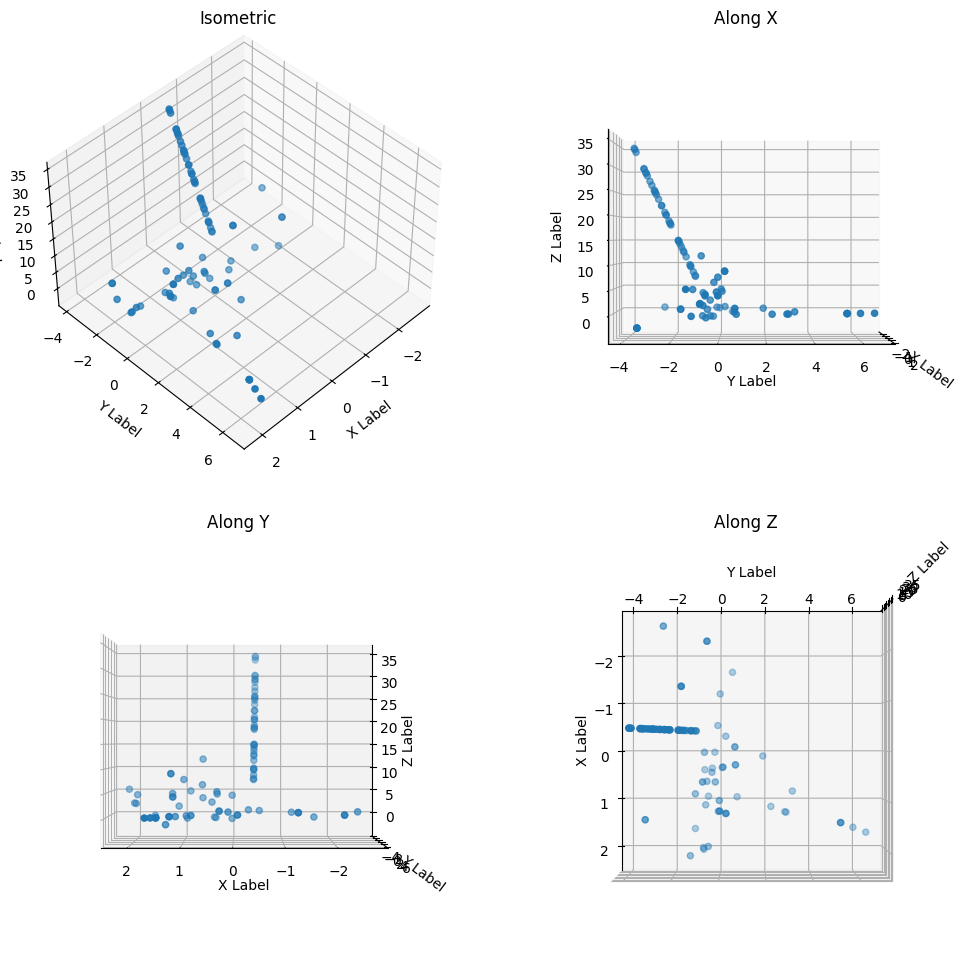

In [11]:
from mpl_toolkits import mplot3d # Allows us to use `view_init()`
import matplotlib.pyplot as plt

def gridview_3d(data, labels):
    titles = ['Isometric', 'Along X', 'Along Y', 'Along Z']
    elevation = [45, 0, 0, 90]
    azimuth = [45, 0, 90, 0]
    
    
    figure, axes = plt.subplots(2,2,figsize=(12,12), subplot_kw=dict(projection='3d'))
    
    for i, ax in enumerate(axes.flat):
        print(f'Plotting {titles[i]}...')
        for label in np.unique(labels):
            ax.scatter(data[labels==label, 0], data[labels==label, 1], data[labels==label, 2])
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_title(titles[i])
        ax.view_init(elevation[i], azimuth[i]) # Allows us to change the orientation
    
    
    plt.show()

gridview_3d(reduced[y_labels!=-1], y_labels[y_labels!=-1])
gridview_3d(reduced[y_labels==-1], y_labels[y_labels==-1])

# <img src="../images/task.png" width=20 height=20> Task 3.10

The question that you should be thinking about is, "Do any of those clusters reveal anything interesting?"  Let's see.  Please write a loop that prints out the first five rows of every cluster found.

Do you see anything interesting?

*Hint:* Don't forget, cluster $-1$ represents values that are not in a cluster.

*Hint:* You might find it useful to attach the labels to the dataframe so that you can easily search for matching rows.

In [12]:
df['cluster'] = y_labels

for cluster in range(-1, len(np.unique(y_labels))-1):
    print(f"===========================\nCluster {cluster}\n")
    print(df.loc[df['cluster']==cluster][:5])

Cluster -1

                                query  qclass  qtype rcode  answers      TTLs  \
150           b.scorecardresearch.com     1.0    1.0     0       85   86479.0   
629                               com     1.0  255.0     5        1      -1.0   
1276  taylorswift.us2.list-manage.com     1.0    1.0     0      119  196395.0   
1375        ads.scorecardresearch.com     1.0    1.0     0       75  104412.0   
1665     2-01-2a40-0017.cdx.cdxcn.net     1.0    1.0     0      112  181008.0   

      qlength  qparts  suffixlength  domainlength  cluster  
150        23       3             3            17       -1  
629         3       1             3             0       -1  
1276       31       4             3            11       -1  
1375       25       3             3            17       -1  
1665       28       4             3             5       -1  
Cluster 0

                                        query  qclass  qtype rcode  answers  \
0          tile-service.weather.microsoft.com

# <img src="../images/task.png" width=20 height=20> Task 3.11

Cluster 20 looks very interesting!  Examine the data in this cluster more closely.  Can you identify the likely source of this data and interpret what it means?


In [13]:
df.loc[df['cluster']==20]

,query,qclass,qtype,rcode,answers,TTLs,qlength,qparts,suffixlength,domainlength,cluster
57018,0msa6bw\xdc\xf48\xbe\xe6yn\xd4\xefh\xdey\xf4i\...,1.0,10.0,-1,1,-1.0,604,7,3,9,20
57019,0yrao\xf0\xf1\xdcna\xeap\xc65jk7\xfaw7p\xebw\x...,1.0,10.0,-1,1,-1.0,568,7,3,9,20
57020,0reaq\xc5pdt\xd3h\xd4\xde\xc0lo\xd1j\xf7p\xeen...,1.0,10.0,-1,1,-1.0,622,7,3,9,20
57021,rbkadcd\xe5d\xbf\xde\xee4cohd\xbf\xde\xee4cohd...,1.0,10.0,-1,1,-1.0,514,7,3,9,20
57022,0auacsk\xeb\xcb\xd3g\xd1lz\xe7\xd0v\xe3e\xbdv\...,1.0,10.0,-1,1,-1.0,622,7,3,9,20
57023,rbkadc\xc1\xe5t\xc7\xe2\xf05c\xccnt\xc7\xe2\xf...,1.0,10.0,-1,1,-1.0,601,7,3,9,20
57024,rbhaddd\xe5j\xcf\xe6\xf26do\xc5j\xcf\xe6\xf26d...,1.0,10.0,-1,1,-1.0,598,7,3,9,20
57025,0u3a2ph\xd1\xd2pe\xe2n\xd1\xc8v\xdbwzb\xe5\xef...,1.0,10.0,-1,1,-1.0,625,7,3,9,20
57028,rbhaded\xe5\xc1\xdf\xee\xf68eph\xc1\xdf\xee\xf...,1.0,10.0,-1,1,-1.0,601,7,3,9,20


In [14]:
df.iloc[57018]

query           0msa6bw\xdc\xf48\xbe\xe6yn\xd4\xefh\xdey\xf4i\...
qclass                                                        1.0
qtype                                                        10.0
rcode                                                          -1
answers                                                         1
TTLs                                                         -1.0
qlength                                                       604
qparts                                                          7
suffixlength                                                    3
domainlength                                                    9
cluster                                                        20
Name: 57018, dtype: object

In [15]:
df.iloc[57018,0]

'0msa6bw\\xdc\\xf48\\xbe\\xe6yn\\xd4\\xefh\\xdey\\xf4i\\xc9x\\xcd\\xe9g\\xe9\\xc0a\\xf5\\xd4kt\\xc5\\xf8\\xbe\\xcc\\xeb\\xe6l\\xd71o\\xea\\xe1o\\xcfq\\xc8cl5\\xee35yg\\xcc\\xd2s\\xea\\xd9.zeq4\\xecamcz\\xd2\\xce\\xe7\\xdfdd\\xd8z\\xd5\\xbf\\xd7qwmr\\xc7\\xfc\\xe6\\xcal\\xdbss\\xd1\\xf3\\xde\\xc8\\xc9\\xd7d\\xda\\xd1x\\xe5sp\\xbd\\xc5txnx\\xechc\\xbd\\xcc\\xd0.f8gt\\xcekj\\xbfj\\xef\\xbf\\xc4isll\\xda\\xf4\\xcf\\xdbz\\xeckn\\xc5\\xceq\\xf3\\xcc\\xed\\xfd\\xca\\xee3ysbx8\\xdd\\xdf9\\xeec\\xf2\\xca\\xd2\\xf3\\xec\\xedj\\xc6ai\\xecw\\xef.\\xd81lj\\xdc\\xfai\\xda\\xd4va0j\\xd4wdf\\xfc7a\\xec\\xd6erq\\xd6s\\xbdh\\xf1\\xe3a\\xbe\\xc2p\\xcc\\xe2ibcmh\\xbf\\xbc\\xf1\\xfbl\\xc6av\\xe85jts\\xe1\\xe8.\\xd1\\xdc.micros0ft.com'


### Cluster value 20

Now *these* are very interesting!  Have a look at an example of one of the full query names:

```
zdzqaabbccddeeffgghhiijjkkllmmnnooppqqrrssttuuvvwwxxyyzz.micros0ft.com
```

All of these queries are involving `micros0ft` and they all involve apparently random strings of letters and other hex values.  What's going on here?

It turns out that the network from which this data was captured was compromised.  During the course of the compromise the attackers installed Iodine, a DNS based covert channel for C2 operations.  What we have just discovered through this clustering approach is all of the Iodine C2 traffic!  Now that's handy.


# Conclusion

As you can see, going back to your original data to see if you can figure out why a cluster is forming can be very valuable.  Of course, since we are still really talking about data exploration, another appropriate activity would be rerunning DBSCAN with different $\epsilon$ and minimum points parameters, in addition to experimenting with changing which columns we preserve in our data.  For example, might it be more interesting if our transformation function were to use the ASCII values of the first few characters in the domain name as a column?  We leave such exploration to you.

In this lab, we have had the opportunity to bring together a number of techniques.  Not only did we learn how to use the DBSCAN algorithm for automatic clustering, but we also applied Principal Component Analysis to allow us to easily visualize the data, we leveraged Matplotlib for that visualization, and Pandas for manipulation of the data.

We also see, again, that these tools are just that: *Tools.*  They do not give us instant answers.  Instead, we use the tools to manipulate the data in various ways to try to transform the data into useful information that we can act on.  In this case, we now can see that there are various potentially interesting clusters in our DNS resolution data; going back to our data to understand *why* these clusters occur and what these clusters *mean* is an organization-unique activity.